# ML Approach

#### We will work with different Datasets. We will work with the Dataset from the BUC station:

In [3]:
#import modules
import numpy as np
import pandas as pd
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.feature_selection import SelectFromModel

#ML packages
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.svm import SVR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#save fitted model:
import pickle
#color palette
colors = sns.color_palette("Set2")
from IPython.display import HTML

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV


## Options for the ML-Algorithms:

In [4]:
#Where to split?
split_date="2018-07-01"
Data="./data/cleaned_data/230516/230516_BUC_2D.csv"

#MODES:
fit_attempt1=True
filename_attempt1 = './data/models_data/230516_GBR_model_HalvingGridSearchCV.sav'

#MODES:
fit_attempt2=True
filename_attempt2 = './data/models_data/230516_GBR_skin_modell_HalvingGridSearchCV.sav'

#MODES:
fit_attempt3=True
filename_attempt3 = './data/models_data/230516_RF_skin_model_HalvingGridSearchCV.sav'

#MODES:
fit_attempt4=True
filename_attempt4 = './data/models_data/230516_SVM_skin_model_GridSearchCV.sav'


BUC_csv= pd.read_csv(Data,index_col="x")
BUC_csv["datetime"]=pd.to_datetime(BUC_csv['datetime'], format="%Y-%m-%d %H:%M:%S")

#add skin effect:
BUC_csv["skin_effect"]=BUC_csv["skin_temp"].subtract(BUC_csv["bulk_temp"])

#add day/night hot encoding:
BUC_csv['day_night'] = BUC_csv['datetime'].dt.hour.apply(lambda x: True if x>=6 and x<18 else False)
try:
    BUC_csv.drop(columns=["Quality"])
except:
    pass

row = BUC_csv.loc[BUC_csv['datetime'] == pd.Timestamp(split_date)]

train_set_raw=BUC_csv[:row.index[0]]
test_set_raw=BUC_csv[row.index[0]:]

print(f"Train set: {len(train_set_raw)} observations, {round((len(train_set_raw)/len(BUC_csv))*100)}% of the whole Dataset")
print(f"Train set: {len(test_set_raw)} observations, {round((len(test_set_raw)/len(BUC_csv))*100)}% of the whole Dataset")


Train set: 12199 observations, 76% of the whole Dataset
Train set: 3760 observations, 24% of the whole Dataset


[]

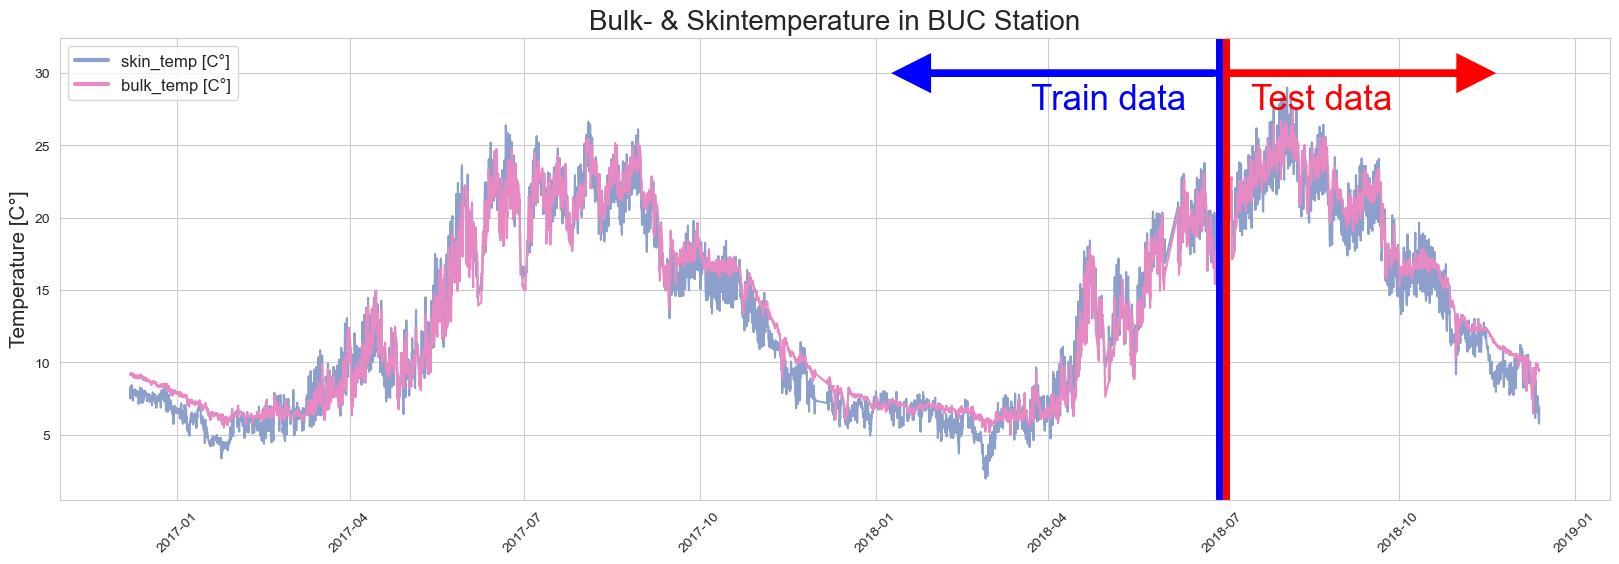

In [151]:
plt.figure(figsize=(20, 6))
plt.plot(BUC_csv["datetime"],BUC_csv["skin_temp"],label="skin_temp [C°]",color=colors[2])
plt.plot(BUC_csv["datetime"],BUC_csv["bulk_temp"],label="bulk_temp [C°]",color=colors[3])

#Vertical Line
plt.axvline(x=pd.Timestamp(split_date)+ pd.DateOffset(2),color="red",linewidth=5)
plt.axvline(x=pd.Timestamp(split_date)- pd.DateOffset(2),color="blue",linewidth=5)

#Arrows
plt.arrow(pd.Timestamp(split_date)+ pd.DateOffset(4),30,120,0,head_width=2, head_length=15, fc='red', ec='red',linewidth=5)
plt.text(pd.Timestamp(split_date)+ pd.DateOffset(15), 27.5, "Test data", fontsize=25,color="red")

plt.arrow(pd.Timestamp(split_date)- pd.DateOffset(4),30,-150,0,head_width=2, head_length=15, fc='blue', ec='blue',linewidth=5)
plt.text(pd.Timestamp(split_date)- pd.DateOffset(100), 27.5, "Train data", fontsize=25,color="blue")
plt.xticks(rotation=45)

#Other things
plt.title("Bulk- & Skintemperature in BUC Station", fontdict={'fontsize': 20})
plt.ylabel("Temperature [C°]", fontdict={'fontsize': 15})
legend=plt.legend(loc="upper left",fontsize="12")
legend.get_lines()[0].set_linewidth(3) # Set linewidth to 3
legend.get_lines()[1].set_linewidth(3) # Set linewidth to 3
plt.plot()

## What is Gradient Boosting Regression?

In [152]:
#CODE:
def apply_table_styles(df):
    return df.style.set_table_styles(
        [
            {
                'selector': 'th',
                'props': [('background-color', 'lightgray')]
            },
            {
                'selector': 'tbody tr:nth-child(even)',
                'props': [('background-color', "lightblue")]
            }
        ]
    )


comparison_dict = {
    'Algorithm': ['Random Forest', 'Gradient Boosting Regression'],
    'Training approach': ['Independent and parallel', 'Sequential and residuals'],
    'Bias-variance tradeoff': ['Higher bias, lower variance', 'Lower bias, higher variance'],
    'Speed': ['Faster for large datasets', 'Slower for large datasets'],
    'Hyperparameters': ['Number of trees, maximum depth', 'Learning rate, number of trees'],
    'Interpretability': ['Lower', 'Higher'],
    'Handling missing values': ['Able to handle missing values', 'Not able to handle missing values'],
    'Robustness to outliers': ['More robust', 'Less robust'],
    'Model performance': ['Stable performance', 'Tendency to overfit']
}

# Convert the dictionary to a pandas DataFrame
comparison_df = pd.DataFrame.from_dict(comparison_dict).T.rename_axis('Algorithm', axis=1).drop(index="Algorithm")
comparison_df.columns = ['Random Forest', 'Gradient Boosting Regression']

# Create a simple dataset
X = np.linspace(0, 10, 100).reshape(-1, 1)
y = np.sin(X).ravel()


# Create Gradient Boosting Regression model
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)

# Train model on data
gbr.fit(X, y)

GradientBoostingRegressor(max_depth=4, random_state=42)

#### What is this algorithm (simple explanation):
The GBR works by combining many decision trees. Each tree tries to fix the mistakes made by the previous trees. The trees are added together, creating an ensemble that makes a prediction.

The hyperparameters of GBR include the number of trees in the ensemble (n_estimators), the learning rate (learning_rate) that controls the contribution of each tree to the ensemble, and the maximum depth of each tree (max_depth), among others.

-> These hyperparameters need to be tuned carefully to obtain the best performance from the model. So we will use the CrossValidationCV module, which is quite good.

An decision tree is visualized below:

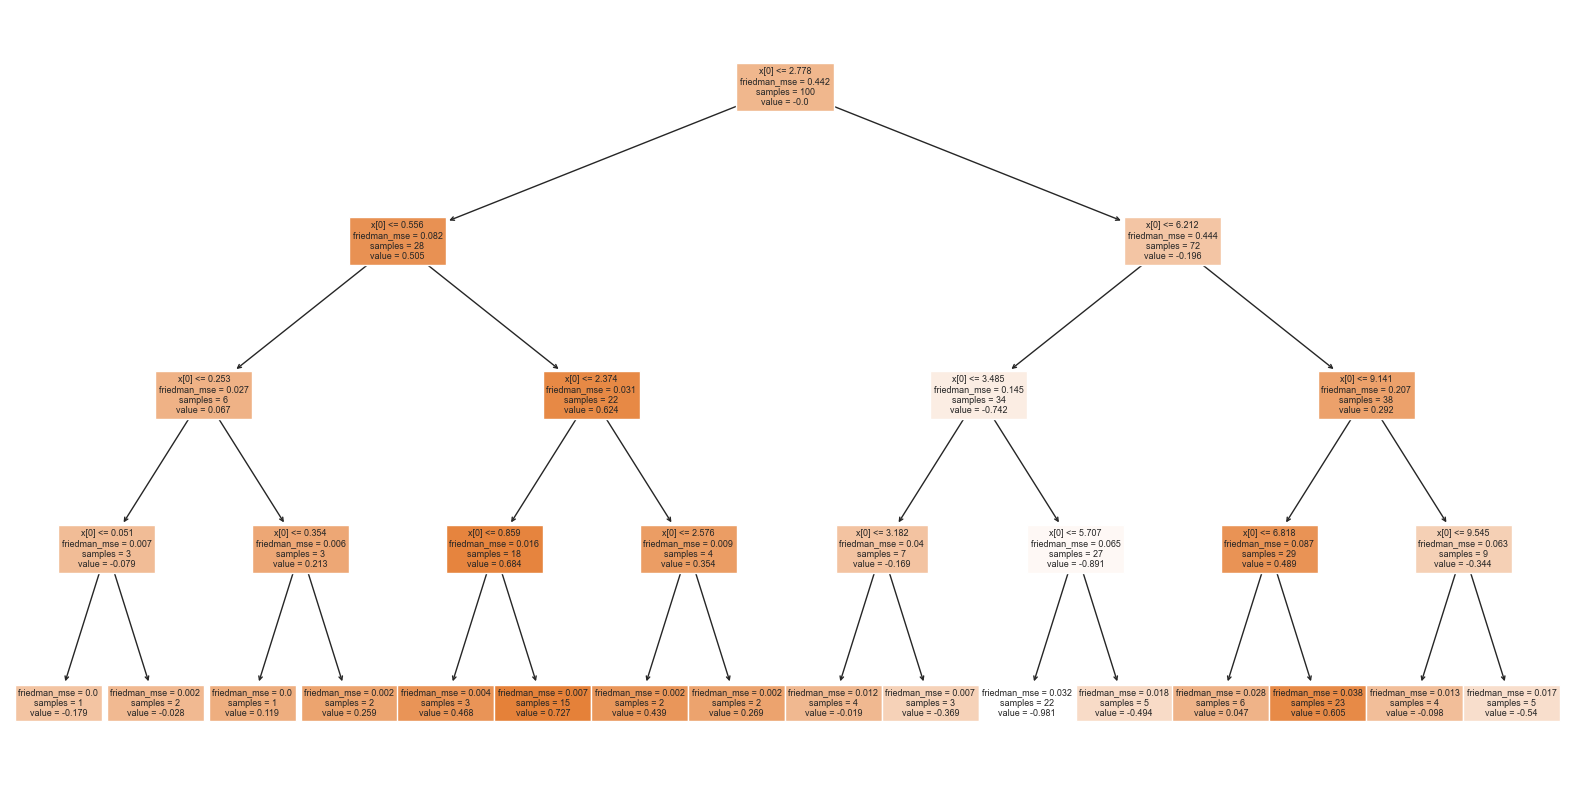

In [153]:
plt.figure(figsize=(20, 10))
plot_tree(gbr.estimators_[0, 0], filled=True)
plt.show()

#### But what is the difference between GBR and RF?

In [154]:
display(apply_table_styles(comparison_df))

,Random Forest,Gradient Boosting Regression
Training approach,Independent and parallel,Sequential and residuals
Bias-variance tradeoff,"Higher bias, lower variance","Lower bias, higher variance"
Speed,Faster for large datasets,Slower for large datasets
Hyperparameters,"Number of trees, maximum depth","Learning rate, number of trees"
Interpretability,Lower,Higher
Handling missing values,Able to handle missing values,Not able to handle missing values
Robustness to outliers,More robust,Less robust
Model performance,Stable performance,Tendency to overfit


## Coding the GBR Model with CrossValidation and Hyperparameter tuning: (Attempt 1: Bulk Temperature and Skin Temperature)

In [155]:
test_set=test_set_raw.copy()
train_set=train_set_raw.copy()
#Grid search is quite useful here:
#define the parameters to choose from
param_grid = {
    "max_depth": [5,7,9],
    "learning_rate": [0.01,0.1],
}
#define the scorer, in this case we can use the mean squared error:
mse_scorer = make_scorer(mean_squared_error,greater_is_better=False)

#initialize the model:
gbr = GradientBoostingRegressor()

#make the GridSearch:

grid_search1 = HalvingGridSearchCV(
    estimator=gbr, #implement the GradienBoostingRegressor
    param_grid=param_grid, #the defined parameters (see above)
    scoring=mse_scorer, #the lower the score (in this case the mse), the better the model
    cv=5, #5-fold Cross Validation -> quite normal here!
    n_jobs=-1, #use 1 core of the CPU
    verbose=10,#print progress messages
    factor=2,
    resource="n_estimators",
    max_resources=500
)
#fit it to the train-set: if False, the fitted model will be loaded from disk:
if fit_attempt1 == True:
    grid_search1.fit(train_set.drop(columns=["bulk_temp","datetime"]),train_set["bulk_temp"])
    pickle.dump(grid_search1, open(filename_attempt1, 'wb'))

else:
    grid_search1 = pickle.load(open(filename_attempt1, 'rb'))


#get the best hyperparameters and the mse:
best_params = grid_search1.best_params_
best_score = grid_search1.best_score_
print("----------------------------")
print("Best Parameters:",best_params)
print("Best Score (MSE):",best_score)


----------------------------
Best Parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 20}
Best Score (MSE): -33.73792008914366


In [156]:
best_estimator = grid_search1.best_estimator_
features = train_set.drop(columns=["bulk_temp","datetime"])
importances = best_estimator.feature_importances_
feature_importances=pd.DataFrame({"feature name": train_set.drop(columns=["bulk_temp","datetime"]).columns,"importance": best_estimator.feature_importances_})
print(feature_importances.sort_values("importance",ascending=False))

    feature name    importance
0      skin_temp  9.753703e-01
7    skin_effect  2.439158e-02
1       air_temp  2.003424e-04
3      windspeed  3.126143e-05
5   rel_humidity  5.535782e-06
4        solar_W  9.534795e-07
2  precipitation  0.000000e+00
6   air_pressure  0.000000e+00
8      day_night  0.000000e+00


In [157]:
# Evaluate the best model on the testing set
test_set=test_set.copy()
test_set["bulk_temp_predicted"]= grid_search1.predict(test_set.drop(columns=["bulk_temp","datetime"]))

mse=mean_squared_error(test_set["bulk_temp_predicted"],test_set["bulk_temp"])
r2=r2_score(test_set["bulk_temp"],test_set["bulk_temp_predicted"])
n = len(test_set["bulk_temp"])  # number of observations
p = 5  # number of predictors (features)
r2_adjusted = 1 - (1 - r2) * (n - 1) / (n - p - 1)

----------------------------------
Mean Squared Error: 33.573
R-squared score: -0.332
Adjusted R-squared score: -0.334
----------------------------------


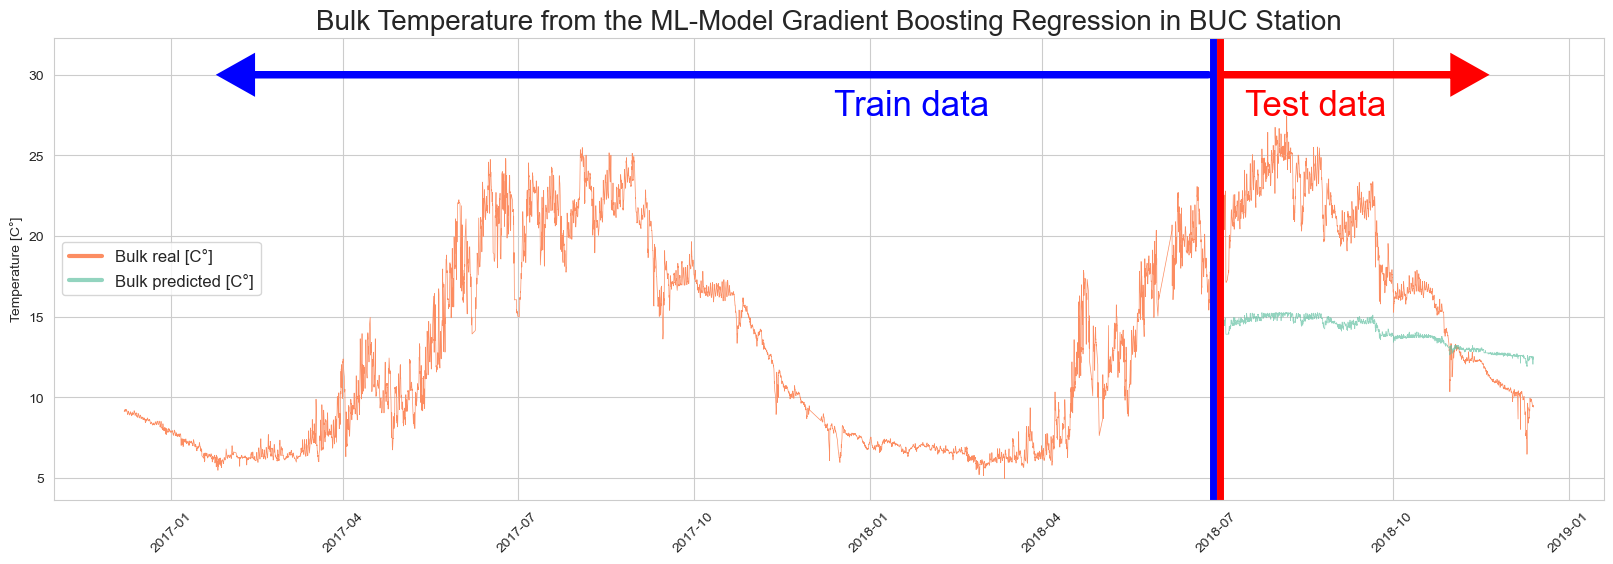

In [158]:

plt.figure(figsize=(20, 6))
plt.plot(BUC_csv["datetime"],BUC_csv["bulk_temp"],label="Bulk real [C°]", color=colors[1],alpha=1,linewidth =0.5)
plt.plot(test_set["datetime"],test_set["bulk_temp_predicted"],label="Bulk predicted [C°]", color=colors[0],alpha=0.7,linewidth =0.5)
plt.xticks(rotation=45)

#Vertical Line
plt.axvline(x=pd.Timestamp(split_date)+ pd.DateOffset(2),color="red",linewidth=5)
plt.axvline(x=pd.Timestamp(split_date)- pd.DateOffset(2),color="blue",linewidth=5)

#Arrows
plt.arrow(pd.Timestamp(split_date)+ pd.DateOffset(4),30,120,0,head_width=2, head_length=15, fc='red', ec='red',linewidth=5)
plt.text(pd.Timestamp(split_date)+ pd.DateOffset(15), 27.5, "Test data", fontsize=25,color="red")

plt.arrow(pd.Timestamp(split_date)- pd.DateOffset(4),30,-500,0,head_width=2, head_length=15, fc='blue', ec='blue',linewidth=5)
plt.text(pd.Timestamp(split_date)- pd.DateOffset(200), 27.5, "Train data", fontsize=25,color="blue")

#Other things
plt.title("Bulk Temperature from the ML-Model Gradient Boosting Regression in BUC Station", fontdict={'fontsize': 20})
plt.ylabel("Temperature [C°]")
legend=plt.legend(fontsize="12")
legend.get_lines()[0].set_linewidth(3) # Set linewidth to 3
legend.get_lines()[1].set_linewidth(3) # Set linewidth to 3


print(f"\033[94m----------------------------------\033[0m")
print(f"\033[94mMean Squared Error: {round(mse,3)}\nR-squared score: {round(r2,3)}\nAdjusted R-squared score: {round(r2_adjusted,3)}\033[0m")
print(f"\033[94m----------------------------------\033[0m")


### Model evaluation:

Lets see how the difference between the predicted and the real bulk temperature is:

In [159]:
display("Real Bulk Temperature minus Skin Temperature")
frame=(test_set["bulk_temp"]-test_set["skin_temp"]).describe().to_frame()
display(apply_table_styles(frame))

display("Predicted Bulk Temperature minus Skin Temperature")
frame=(test_set["bulk_temp_predicted"]-test_set["skin_temp"]).describe().to_frame()
display(apply_table_styles(frame))

display("Predicted Bulk Temperature minus real Bulk Temperature")
frame=(test_set["bulk_temp_predicted"]-test_set["bulk_temp"]).describe().to_frame()
display(apply_table_styles(frame))

display("We can see that the interpretation is quite challanging. Another option is to train the model on Bulk Temperature - Skin Temperature to predict the Skin effect itself")

'Real Bulk Temperature minus Skin Temperature'

,0
count,3760.000000
mean,0.774518
std,1.102253
min,-3.691588
25%,0.100544
50%,0.845351
75%,1.548361
max,3.698130


'Predicted Bulk Temperature minus Skin Temperature'

,0
count,3760.000000
mean,-3.291906
std,4.551322
min,-14.248612
25%,-7.067533
50%,-3.994445
75%,0.983841
max,6.463152


'Predicted Bulk Temperature minus real Bulk Temperature'

,0
count,3760.000000
mean,-4.066423
std,4.128122
min,-12.159973
25%,-7.588407
50%,-4.015728
75%,0.203197
max,5.497716


'We can see that the interpretation is quite challanging. Another option is to train the model on Bulk Temperature - Skin Temperature to predict the Skin effect itself'

## Coding the GBR Model with CrossValidation and Hyperparameter tuning: (Attempt 2: Skin Effect)

In [160]:
test_set=test_set_raw.copy()
train_set=train_set_raw.copy()

#Grid search is quite useful here:
#define the parameters to choose from
param_grid = {
    "max_depth": [5,7,9],
    "learning_rate": [0.01,0.1],
}
#define the scorer, in this case we can use the mean squared error:
mse_scorer = make_scorer(r2_score)

#initialize the model:
gbr = GradientBoostingRegressor()

#make the GridSearch:

grid_search2 = HalvingGridSearchCV(
    estimator=gbr, #implement the GradienBoostingRegressor
    param_grid=param_grid, #the defined parameters (see above)
    scoring=mse_scorer, #the lower the score (in this case the mse), the better the model
    cv=5, #5-fold Cross Validation -> quite normal here!
    n_jobs=-1, #use 1 core of the CPU
    verbose=10,#print progress messages
    factor=2,
    resource="n_estimators",
    max_resources=2500
)
#fit it to the train-set: if False, the fitted model will be loaded from disk:
if fit_attempt2 == True:
    grid_search2.fit(train_set.drop(columns=["skin_effect","datetime"]),train_set["skin_effect"])
    pickle.dump(grid_search2, open(filename_attempt2, 'wb'))

else:
    grid_search2 = pickle.load(open(filename_attempt2, 'rb'))


#get the best hyperparameters and the mse:
best_params = grid_search2.best_params_
best_score = grid_search2.best_score_
print("----------------------------")
print("Best Parameters:",best_params)
print("Best Score (r2):",best_score)

----------------------------
Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 20}
Best Score (r2): -0.46429008192633725


In [161]:
test_set=test_set.copy()
test_set["skin_effect_predicted"]= grid_search2.predict(test_set.drop(columns=["skin_effect","datetime"]))

mse=mean_squared_error(test_set["skin_effect_predicted"],test_set["skin_effect"])
r2=r2_score(test_set["skin_effect"],test_set["skin_effect_predicted"])
n = len(test_set["skin_effect"])  # number of observations
p = 7  # number of predictors (features)
r2_adjusted = 1 - (1 - r2) * (n - 1) / (n - p - 1)

----------------------------------
Mean Squared Error: 1.021
R-squared score: 0.159
Adjusted R-squared score: 0.158
    feature name  importance
2  precipitation    0.586319
0      skin_temp    0.361157
5   rel_humidity    0.028800
1       air_temp    0.022979
6   air_pressure    0.000745
3      windspeed    0.000000
4        solar_W    0.000000
7    skin_effect    0.000000
8      day_night    0.000000


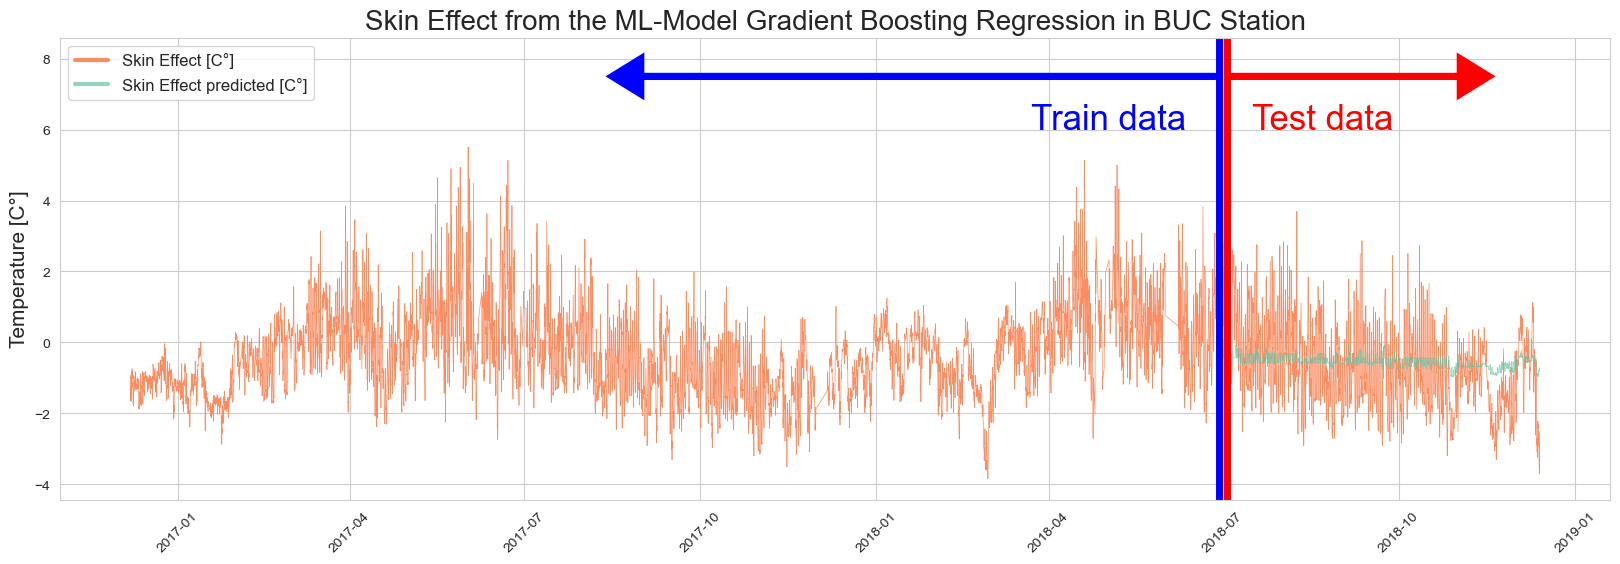

In [162]:
plt.figure(figsize=(20, 6))
plt.plot(BUC_csv["datetime"],BUC_csv["skin_effect"],label="Skin Effect [C°]", color=colors[1],alpha=1,linewidth =0.5)
plt.plot(test_set["datetime"],test_set["skin_effect_predicted"],label="Skin Effect predicted [C°]", color=colors[0],alpha=0.7,linewidth =0.5)
plt.xticks(rotation=45)

#Vertical Line
plt.axvline(x=pd.Timestamp(split_date)+ pd.DateOffset(2),color="red",linewidth=5)
plt.axvline(x=pd.Timestamp(split_date)- pd.DateOffset(2),color="blue",linewidth=5)

#Arrows
plt.arrow(pd.Timestamp(split_date)+ pd.DateOffset(4),7.5,120,0,head_width=1, head_length=15, fc='red', ec='red',linewidth=5)
plt.text(pd.Timestamp(split_date)+ pd.DateOffset(15), 6, "Test data", fontsize=25,color="red")

plt.arrow(pd.Timestamp(split_date)- pd.DateOffset(4),7.5,-300,0,head_width=1, head_length=15, fc='blue', ec='blue',linewidth=5)
plt.text(pd.Timestamp(split_date)- pd.DateOffset(100), 6, "Train data", fontsize=25,color="blue")

#Other things
plt.title("Skin Effect from the ML-Model Gradient Boosting Regression in BUC Station", fontdict={'fontsize': 20})
plt.ylabel("Temperature [C°]", fontdict={'fontsize': 15})
legend=plt.legend(loc="upper left",fontsize="12")
legend.get_lines()[0].set_linewidth(3) # Set linewidth to 3
legend.get_lines()[1].set_linewidth(3) # Set linewidth to 3
print(f"\033[94m----------------------------------\033[0m")
print(f"\033[94mMean Squared Error: {round(mse,3)}\nR-squared score: {round(r2,3)}\nAdjusted R-squared score: {round(r2_adjusted,3)}\033[0m")


#best estimator:
best_estimator = grid_search2.best_estimator_
features = train_set.drop(columns=["bulk_temp","datetime"])
importances = best_estimator.feature_importances_
feature_importances=pd.DataFrame({"feature name": train_set.drop(columns=["bulk_temp","datetime"]).columns,"importance": best_estimator.feature_importances_})
print(feature_importances.sort_values("importance",ascending=False))


## Coding a RF Model with CrossValidation and Hyperparameter tuning: (Attempt 3: Skin Effect)


What is a Random Forest Model?

-> A Random Forest Model is a ML-Model that combines multiple Decision Trees to Classify or Predict from multivariate Data. This model tends to be more robust as the GBR (more details see below).

In [163]:
display(apply_table_styles(comparison_df))

,Random Forest,Gradient Boosting Regression
Training approach,Independent and parallel,Sequential and residuals
Bias-variance tradeoff,"Higher bias, lower variance","Lower bias, higher variance"
Speed,Faster for large datasets,Slower for large datasets
Hyperparameters,"Number of trees, maximum depth","Learning rate, number of trees"
Interpretability,Lower,Higher
Handling missing values,Able to handle missing values,Not able to handle missing values
Robustness to outliers,More robust,Less robust
Model performance,Stable performance,Tendency to overfit


In [164]:
test_set=test_set_raw.copy()
train_set=train_set_raw.copy()
#Grid search is quite useful here:
#define the parameters to choose from
param_grid = {
    "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
    "max_depth": [3,7,9,12],
    #"min_samples_split": [2]
}
#define the scorer, in this case we can use the mean squared error:
scorer = make_scorer(r2_score)
#scorer = make_scorer(mean_absolute_error)

#initialize the model:
rfr = RandomForestRegressor()

#make the GridSearch:

grid_search3 = HalvingGridSearchCV(
    estimator=rfr, #implement the GradienBoostingRegressor
    param_grid=param_grid, #the defined parameters (see above)
    scoring=mse_scorer, #the lower the score (in this case the mse), the better the model
    cv=5, #5-fold Cross Validation -> quite normal here!
    n_jobs=-1, #use 1 core of the CPU
    verbose=10,#print progress messages
    factor=2,
    resource="n_estimators",
    max_resources=2500
)
#fit it to the train-set: if False, the fitted model will be loaded from disk:
if fit_attempt3 == True:
    grid_search3.fit(train_set.drop(columns=["skin_effect","datetime","bulk_temp"]),train_set["skin_effect"])
    pickle.dump(grid_search3, open(filename_attempt3, 'wb'))

else:
    grid_search3 = pickle.load(open(filename_attempt3, 'rb'))


#get the best hyperparameters and the mse:
best_params = grid_search3.best_params_
best_score = grid_search3.best_score_
print("----------------------------")
print("Best Parameters:",best_params)
print("Best Score (mae):",best_score)

----------------------------
Best Parameters: {'criterion': 'friedman_mse', 'max_depth': 9, 'n_estimators': 20}
Best Score (mae): 0.05331270380833151


In [165]:
test_set=test_set.copy()
test_set["skin_effect_predicted"]= grid_search3.predict(test_set.drop(columns=["skin_effect","datetime","bulk_temp"]))

mse=mean_squared_error(test_set["skin_effect_predicted"],test_set["skin_effect"])
r2=r2_score(test_set["skin_effect"],test_set["skin_effect_predicted"])
n = len(test_set["skin_effect"])  # number of observations
p = 5  # number of predictors (features)
r2_adjusted = 1 - (1 - r2) * (n - 1) / (n - p - 1)

----------------------------------
Mean Squared Error: 0.507
R-squared score: 0.582
Adjusted R-squared score: 0.582

Feature Importance:
    feature name  importance
0       air_temp    0.604684
1      skin_temp    0.276907
2        solar_W    0.048810
3   rel_humidity    0.036666
4      windspeed    0.031282
5      day_night    0.001651
6  precipitation    0.000000
7   air_pressure    0.000000
----------------------------------


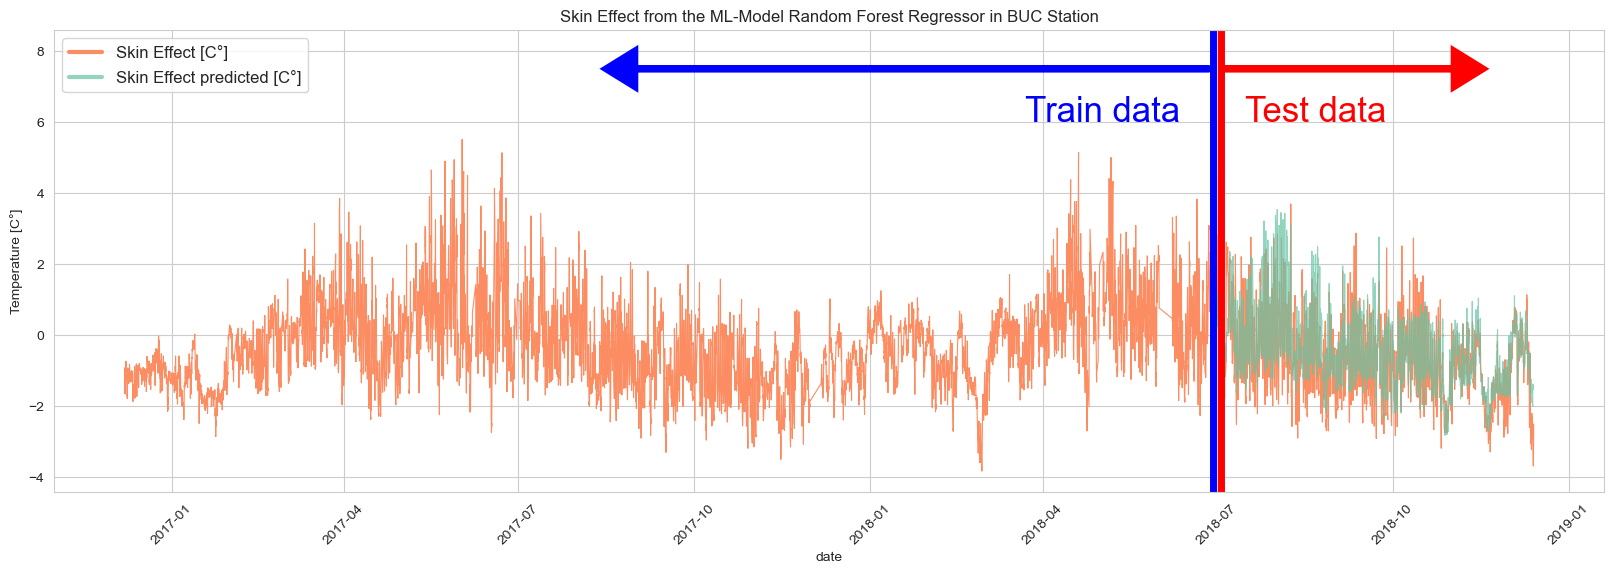

In [166]:
plt.figure(figsize=(20, 6))
plt.plot(BUC_csv["datetime"],BUC_csv["skin_effect"],label="Skin Effect [C°]", color=colors[1],alpha=1,linewidth =0.8)
plt.plot(test_set["datetime"],test_set["skin_effect_predicted"],label="Skin Effect predicted [C°]", color=colors[0],alpha=0.7,linewidth =0.8)
plt.xticks(rotation=45)

#Vertical Line
plt.axvline(x=pd.Timestamp(split_date)+ pd.DateOffset(2),color="red",linewidth=5)
plt.axvline(x=pd.Timestamp(split_date)- pd.DateOffset(2),color="blue",linewidth=5)

#Arrows
plt.arrow(pd.Timestamp(split_date)+ pd.DateOffset(4),7.5,120,0,head_width=1, head_length=15, fc='red', ec='red',linewidth=5)
plt.text(pd.Timestamp(split_date)+ pd.DateOffset(15), 6, "Test data", fontsize=25,color="red")

plt.arrow(pd.Timestamp(split_date)- pd.DateOffset(4),7.5,-300,0,head_width=1, head_length=15, fc='blue', ec='blue',linewidth=5)
plt.text(pd.Timestamp(split_date)- pd.DateOffset(100), 6, "Train data", fontsize=25,color="blue")

#Other things
plt.title("Skin Effect from the ML-Model Random Forest Regressor in BUC Station")
plt.xlabel("date")
plt.ylabel("Temperature [C°]")
legend=plt.legend(fontsize="12",loc="upper left")
legend.get_lines()[0].set_linewidth(3) # Set linewidth to 3
legend.get_lines()[1].set_linewidth(3) # Set linewidth to 3

print(f"\033[94m----------------------------------\033[0m")
print(f"\033[94mMean Squared Error: {round(mse,3)}\nR-squared score: {round(r2,3)}\nAdjusted R-squared score: {round(r2_adjusted,3)}\033[0m")


#best estimator:
best_estimator= grid_search3.best_estimator_
feature_importances=pd.DataFrame({"feature name": train_set.drop(columns=["skin_effect","datetime","bulk_temp"]).columns,"importance": best_estimator.feature_importances_})
print("")
print(f"\033[94mFeature Importance:\033[0m")
print(f"\033[94m{feature_importances.sort_values('importance',ascending=False).reset_index(drop=True)}\033[0m")
print(f"\033[94m----------------------------------\033[0m")

## Coding a SVM Model with CrossValidation and Hyperparameter tuning: (Attempt 4: Skin Effect)


In [ ]:
test_set=test_set_raw.copy()
train_set=train_set_raw.copy()
#Grid search is quite useful here:
#define the parameters to choose from
param_grid = {
    "C": [0.1,0,10],
    "kernel": ["linear", "rbf"],
}
#define the scorer, in this case we can use the mean squared error:

#initialize the model:
rfr = SVR()

#make the GridSearch:

grid_search4 = GridSearchCV(
    estimator=rfr, #implement the GradienBoostingRegressor
    param_grid=param_grid, #the defined parameters (see above)
    cv=5, #5-fold Cross Validation -> quite normal here!
    n_jobs=-1, #use 1 core of the CPU
    verbose=10,#print progress messages
)
#fit it to the train-set: if False, the fitted model will be loaded from disk:
if fit_attempt4 == True:
    grid_search4.fit(train_set.drop(columns=["skin_effect","datetime","bulk_temp"]),train_set["skin_effect"])
    pickle.dump(grid_search3, open(filename_attempt3, 'wb'))

else:
    grid_search3 = pickle.load(open(filename_attempt3, 'rb'))


#get the best hyperparameters and the mse:
best_params = grid_search4.best_params_
best_score = grid_search4.best_score_
print("----------------------------")
print("Best Parameters:",best_params)
print("Best Score:",best_score)

test_set=test_set.copy()
test_set["skin_effect_predicted"]= grid_search4.predict(test_set.drop(columns=["skin_effect","bulk_temp","datetime"]))

mse=mean_squared_error(test_set["skin_effect_predicted"],test_set["skin_effect"])
r2=r2_score(test_set["skin_effect"],test_set["skin_effect_predicted"])
n = len(test_set["skin_effect"])  # number of observations
p = 5  # number of predictors (features)
r2_adjusted = 1 - (1 - r2) * (n - 1) / (n - p - 1)


plt.figure(figsize=(20, 6))
plt.plot(BUC_csv["datetime"],BUC_csv["skin_effect"],label="Skin Effect [C°]", color=colors[1],alpha=1,linewidth =0.8)
plt.plot(test_set["datetime"],test_set["skin_effect_predicted"],label="Skin Effect predicted [C°]", color=colors[0],alpha=0.7,linewidth =0.8)
plt.xticks(rotation=45)

#Vertical Line
plt.axvline(x=pd.Timestamp(split_date)+ pd.DateOffset(2),color="red",linewidth=5)
plt.axvline(x=pd.Timestamp(split_date)- pd.DateOffset(2),color="blue",linewidth=5)

#Arrows
plt.arrow(pd.Timestamp(split_date)+ pd.DateOffset(4),7.5,120,0,head_width=1, head_length=15, fc='red', ec='red',linewidth=5)
plt.text(pd.Timestamp(split_date)+ pd.DateOffset(15), 6, "Test data", fontsize=25,color="red")

plt.arrow(pd.Timestamp(split_date)- pd.DateOffset(4),7.5,-300,0,head_width=1, head_length=15, fc='blue', ec='blue',linewidth=5)
plt.text(pd.Timestamp(split_date)- pd.DateOffset(100), 6, "Train data", fontsize=25,color="blue")

#Other things
plt.title("Skin Effect from the ML-Model Support Vector Regressor in BUC Station")
plt.xlabel("date")
plt.ylabel("Temperature [C°]")
legend=plt.legend(fontsize="12",loc="upper left")
legend.get_lines()[0].set_linewidth(3) # Set linewidth to 3
legend.get_lines()[1].set_linewidth(3) # Set linewidth to 3

print(f"\033[94m----------------------------------\033[0m")
print(f"\033[94mMean Squared Error: {round(mse,3)}\nR-squared score: {round(r2,3)}\nAdjusted R-squared score: {round(r2_adjusted,3)}\033[0m")


#best estimator:
best_estimator= grid_search4.best_estimator_
feature_importances=pd.DataFrame({"feature name": train_set.drop(columns=["skin_effect","bulk_temp","datetime"]).columns,"importance": best_estimator.coef_[0]})
print("")
print(f"\033[94mFeature Importance:\033[0m")
print(f"\033[94m{feature_importances.sort_values('importance',ascending=False).reset_index(drop=True)}\033[0m")
print(f"\033[94m----------------------------------\033[0m")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START C=0.1, kernel=linear........................................
